In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
from touschek.touschek import get_LamTska, get_Touschek_Lifetime_Lebedev,\
                                get_Touschek_Lifetime_Valishev
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

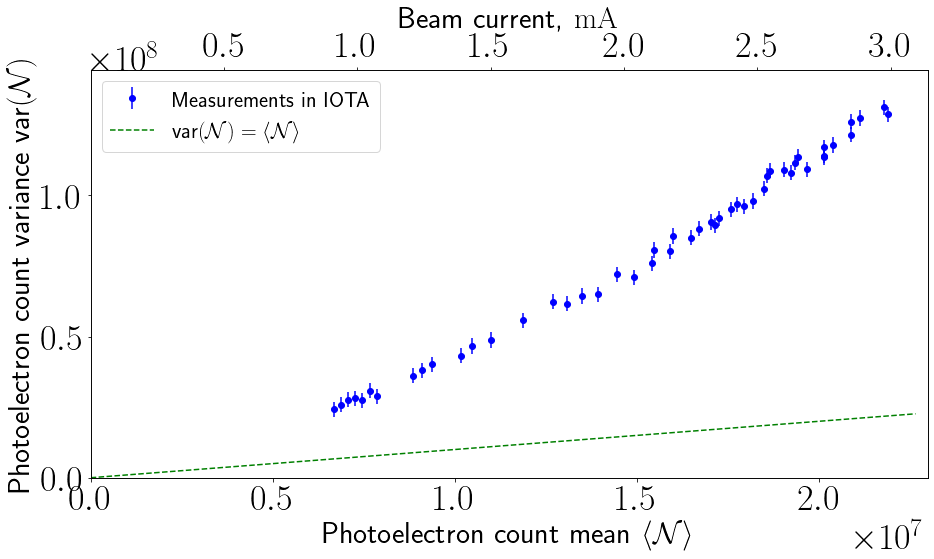

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [4]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [5]:
es = df.columns.values.astype(np.float64)

In [6]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [7]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [8]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [9]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [10]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [11]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [12]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [13]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [15]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [16]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [17]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [18]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
sx_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_r_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_r_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_r_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [19]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


In [20]:
from scipy import integrate
from scipy.special import iv

def ExI0(a,b):
    if b<40:
        return np.exp(-a)*iv(0,b)
    else:
        return np.exp(-a+b)/np.sqrt(2*np.pi*b)\
                * (1+1/8/b+9/128/b**2+9*25/6/8**3/b**3)

def Ku(u, um, B1, B2):
    return np.sqrt(u/(1+u))*ExI0(B1*u, B2*u)\
        * ((2+1/u)**2*(u/um/(1+u)-1)+1-np.sqrt(um*(1+u)/u)\
        - 1/2/u*(4+1/u)*np.log(u/um/(1+u)))

def Itsk(um, B1, B2):
    return integrate.quad(lambda u: Ku(u, um, B1, B2), um, np.inf)



In [21]:
ldf = lattice_df
ldf.head()

,S_cm,Dispersion_cm_X,Beta_cm_X,Beta_cm_Y,Alpha_X,Alpha_Y,dS,dDx,dDx/dS,Phi_X,H
0,0.000000,-24.202678,79.069986,115.457907,3.815143e-07,-1.043665e-07,4.666667,-3.552714e-15,-7.612958e-16,-1.167784e-07,7.408242
1,4.666667,-24.202678,79.345437,115.646529,-5.902559e-02,-4.041888e-02,4.666667,-3.552714e-15,-7.612958e-16,1.800453e-02,7.408245
2,9.333333,-24.202678,80.171797,116.212393,-1.180516e-01,-8.083765e-02,4.666667,0.000000e+00,0.000000e+00,3.563802e-02,7.408254
3,14.000000,-24.202678,81.549066,117.155498,-1.770775e-01,-1.212564e-01,4.666667,-3.552714e-15,-7.612958e-16,5.255426e-02,7.408267
4,18.604167,-24.202678,83.447781,118.455670,-2.353130e-01,-1.611339e-01,4.604167,-3.552714e-15,-7.716301e-16,6.824872e-02,7.408285


In [22]:
NN = len(ldf.index)
M = np.zeros(shape=(NN, 5, 5))
M[:,3,1] = np.sqrt(ldf['Beta_cm_X'])
M[:,2,1] = ldf['Alpha_X']/np.sqrt(ldf['Beta_cm_X'])
M[:,2,2] = 1/np.sqrt(ldf['Beta_cm_X'])
M[:,1,3] = np.sqrt(ldf['Beta_cm_Y'])
M[:,0,3] = ldf['Alpha_Y']/np.sqrt(ldf['Beta_cm_Y'])
M[:,0,4] = 1/np.sqrt(ldf['Beta_cm_Y'])

In [23]:
M[0,3,1]

8.892130544201313

In [24]:
M[0,3,2]

0.0

In [25]:
M[0,2,1]

4.2904709958266124e-08

In [26]:
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
lt_df = pd.read_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"),
            index_col=0)
lt_df['N'] = i_to_photoel*lt_df['I (mA)']

aperture_factor=1
re = 2.817941e-13  # cm
row = lt_df.loc[0, :]
Ibeam = row['I (mA)']
lt = row['Beam life time (Sec)']
avN = row['N']
V0 = Vrf_f_func(avN)
sp = dpp_f_func(avN)
ex = ex_f_func(avN)
ey = ey_f_func(avN)
sz = sz_f_func(avN)

gamma = get_from_config("gamma")
e = get_from_config("e")
c = get_from_config("c_m/s")*100
me = get_from_config("me_MeV")*1e6
alpha = get_from_config("ring_alpha")
q = get_from_config("RF_q")
VSR = get_from_config("VSR")
f0 = 1/get_from_config("IOTA_revolution_period")
fRF = q*f0
lamRF = c/fRF


etas = alpha-1/gamma**2
Ks = (alpha*gamma**2-1)/(gamma**2-1)
phiacc = np.arcsin(VSR/V0)
nus0 = np.sqrt(q*V0*np.abs(Ks)/2/np.pi/me/gamma)
nus = nus0*np.sqrt(np.cos(phiacc))
fs = f0*nus
dP_Psep = aperture_factor*2*nus0/q/np.abs(etas)*np.sqrt(np.cos(phiacc)
                                        - (np.pi/2-phiacc)*np.sin(phiacc))
Gs = lamRF/2/np.pi*q/nus*np.abs(etas)


ldf['Sigma_um_X'] = lattice.get_sigma_um(ldf['Beta_cm_X'], ex,
                                         ldf['Dispersion_cm_X'], sp)


aux1 = ldf['Beta_cm_X']/ex/1e-4/(
        1+(sp*ldf['Beta_cm_X']*ldf["Phi_X"]/ldf["Sigma_um_X"]/1e-4)**2)

aux2 = ldf['Beta_cm_Y']/ey/1e-4

B1 = 1/2/gamma**2*np.abs(aux1 + aux2)
B2 = 1/2/gamma**2*np.abs(aux1 - aux2)

S33 = 1/sp**2 + ldf['H']/ex/1e-4

Ne = Ibeam*1e-3/f0/e

um = dP_Psep**2
Itski = np.array([Itsk(um, b1, b2)[0] for b1,b2 in zip(B1, B2)])



sum_components = Itski/np.sqrt(S33)*ldf['dS']/(1/f0)
LamTska = Ne*re**2/(8*np.sqrt(np.pi)*gamma**4*ex*1e-4*ey*1e-4*sz*sp)\
    * sum_components.sum()
1/LamTska

1128.4099005254252

In [27]:
e1, e2 = 1e-4*ex, 1e-4*ey

In [28]:
Axx = (M[:,2,1]**2+M[:,2,2]**2)/2/e1+(M[:,2,3]**2+M[:,2,4]**2)/2/e2
Ayy = (M[:,0,1]**2+M[:,0,2]**2)/2/e1+(M[:,0,3]**2+M[:,0,4]**2)/2/e2
Apxpx = (M[:,3,1]**2+M[:,3,2]**2)/2/e1+(M[:,3,3]**2+M[:,3,4]**2)/2/e2
Apypy = (M[:,1,1]**2+M[:,1,2]**2)/2/e1+(M[:,1,3]**2+M[:,1,4]**2)/2/e2
Axpx = -2*((M[:,3,1]*M[:,2,1]+M[:,3,2]*M[:,2,2])/2/e1\
        + (M[:,3,3]*M[:,2,3]+M[:,3,4]*M[:,2,4])/2/e2)
Aypy = -2*((M[:,1,1]*M[:,0,1]+M[:,1,2]*M[:,0,2])/2/e1\
        + (M[:,1,3]*M[:,0,3]+M[:,1,4]*M[:,0,4])/2/e2)
Axy = 2*((M[:,2,1]*M[:,0,1]+M[:,2,2]*M[:,0,2])/2/e1\
        + (M[:,2,3]*M[:,0,3]+M[:,2,4]*M[:,0,4])/2/e2)
Apxpy = 2*((M[:,3,1]*M[:,1,1]+M[:,3,2]*M[:,1,2])/2/e1\
        + (M[:,3,3]*M[:,1,3]+M[:,3,4]*M[:,1,4])/2/e2)
Axpy = -2*((M[:,2,1]*M[:,1,1]+M[:,2,2]*M[:,1,2])/2/e1\
        + (M[:,2,3]*M[:,1,3]+M[:,2,4]*M[:,1,4])/2/e2)
Aypx = -2*((M[:,3,1]*M[:,0,1]+M[:,3,2]*M[:,0,2])/2/e1\
          + (M[:,3,3]*M[:,0,3]+M[:,3,4]*M[:,0,4])/2/e2)

In [29]:
Fx = Apxpx-Axpx**2/4/Axx-1/4*(Aypx-Axpx*Axy/2/Axx)**2/(Ayy-Axy**2/4/Axx)
Fy = Apypy-Axpy**2/4/Axx-1/4*(Aypy-Axpy*Axy/2/Axx)**2/(Ayy-Axy**2/4/Axx)
Fpx = Axx - Axpx**2/4/Apxpx-1/4*(Axpy-Axpx*Apxpy/2/Apxpx)**2\
        /(Apypy-Apxpy**2/4/Apxpx)
Fpy = Ayy-Aypx**2/4/Apxpx-1/4*(Aypy-Aypx*Apxpy/2/Apxpx)**2\
        /(Apypy-Apxpy**2/4/Apxpx)
Fxy = Apxpy/2-Axpx*Axpy/2/Axx-1/4*(Aypx-Axpx*Axy/2/Axx)*(Aypy-Axpy*Axy/2/Axx)\
    /(Ayy-Axy**2/4/Axx)
Fpxpy = Axy/2-Axpx*Aypx/4/Apxpx-1/4*(Aypy-Aypx*Apxpy/2/Apxpx)\
    * (Axpy-Axpx*Apxpy/2/Apxpx)/(Apypy-Apxpy**2/4/Apxpx)

In [30]:
from scipy import integrate
from scipy.special import iv

In [31]:
def Pfunc(k):
    Axxk, Ayyk, Axyk, Fxk, Fyk, Fxyk = \
        Axx[k], Ayy[k], Axy[k], Fx[k], Fy[k], Fxy[k] 
    def func(Q):
        return 1/8/e1**2/e2**2/(Axxk*Ayyk-1/4*Axyk**2)\
            /np.sqrt(Fxk*Fyk-Fxyk**2)*np.exp(-Q**2*(Fxk/2+Fyk/2))\
            *iv(0,Q**2*np.sqrt(1/4*(Fyk-Fxk)**2+Fxyk**2))*Q
    return func

In [32]:
Pfunc(0)(0.0)

0.0

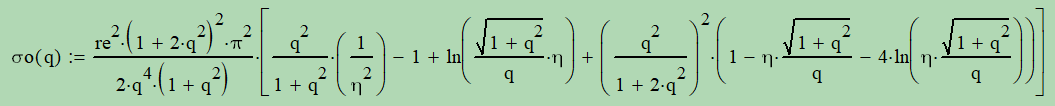

In [33]:
eta = dP_Psep
def s0(q):
    aux1 = re**2*(1+2*q**2)**2*np.pi**2/2/q**4/(1+q**2)
    aux2 = q**2/(1+q**2)*(1/eta**2)-1+np.log(np.sqrt(1+q**2)/q*eta)
    aux3 = (q**2/(1+2*q**2))**2*(1-eta*np.sqrt(1+q**2)/q\
                                 - 4*np.log(eta*np.sqrt(1+q**2)/q))
    return aux1*(aux2+aux3)

In [34]:
qm = eta/np.sqrt(1-eta**2)

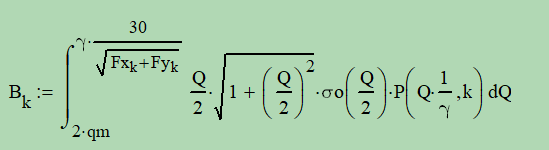

In [35]:
Fx[0]

627193.699672931

In [36]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})

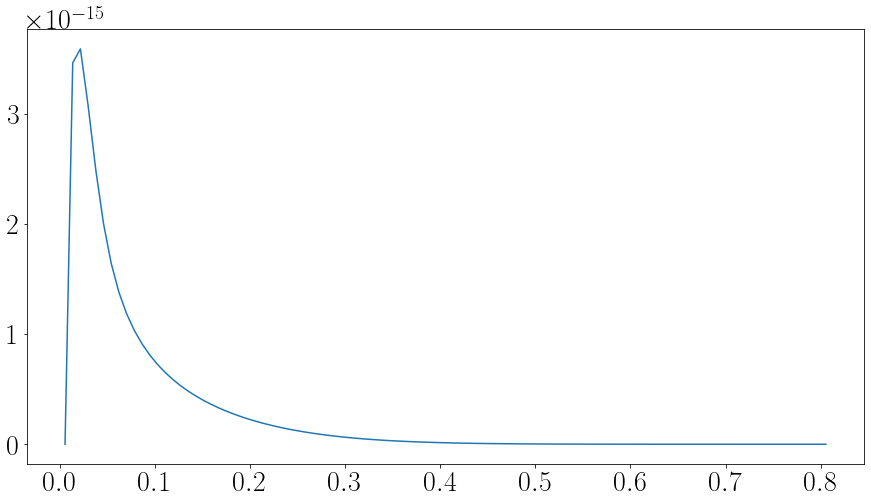

upper limit =  0.805541231869754


(2.41119893135987e-16, 2.501657910455973e-16)

In [37]:
k=0
upper_limit = gamma/np.sqrt(Fx[k]+Fy[k])*30
Qs = np.linspace(2*qm, upper_limit, 100)
def integrand(k):
    Pf = Pfunc(k)
    def res(Q):
        return Q/2*np.sqrt(1+(Q/2)**2)*s0(Q/2)*Pf(Q/gamma)
    return res
f_int = integrand(k)
plt.plot(Qs, f_int(Qs))
plt.show()
print('upper limit = ', upper_limit)
integrate.quad(f_int, 2*qm, upper_limit)


In [38]:
B = []
upper_lim_coef = 30
for k in ldf.index:
    upper_limit = gamma/np.sqrt(Fx[k]+Fy[k])*upper_lim_coef
    f_int = integrand(k)
    B.append(integrate.quad(f_int, 2*qm, upper_limit)[0])
B = np.array(B)
B

array([2.41119893e-16, 2.41119864e-16, 2.41119778e-16, 2.41119638e-16,
       2.41119452e-16, 2.41119226e-16, 2.41118968e-16, 2.41118684e-16,
       2.41118382e-16, 2.41118069e-16, 2.41117752e-16, 2.41117435e-16,
       2.41117123e-16, 2.41116819e-16, 2.41116526e-16, 2.41116245e-16,
       2.41115989e-16, 2.41115745e-16, 2.41115515e-16, 2.41115297e-16,
       2.41115093e-16, 2.04755070e-16, 1.72240098e-16, 1.45503911e-16,
       1.24006082e-16, 1.07144709e-16, 1.07144693e-16, 1.07144681e-16,
       1.07144671e-16, 1.47049489e-16, 2.47387329e-16, 3.78179980e-16,
       1.84418898e-16, 1.22864728e-16, 1.22864739e-16, 1.22864752e-16,
       1.22864771e-16, 1.22864794e-16, 1.22864824e-16, 1.22864861e-16,
       1.22864909e-16, 1.22864973e-16, 1.22865061e-16, 1.22865156e-16,
       1.22865322e-16, 1.22865570e-16, 1.22865848e-16, 1.22866243e-16,
       1.22866801e-16, 1.22867552e-16, 1.32240608e-16, 1.34635843e-16,
       1.22363216e-16, 1.08979934e-16, 9.76756835e-17, 9.76753148e-17,
      

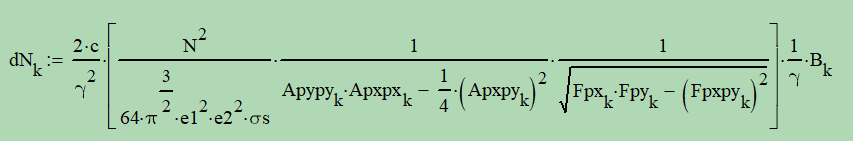

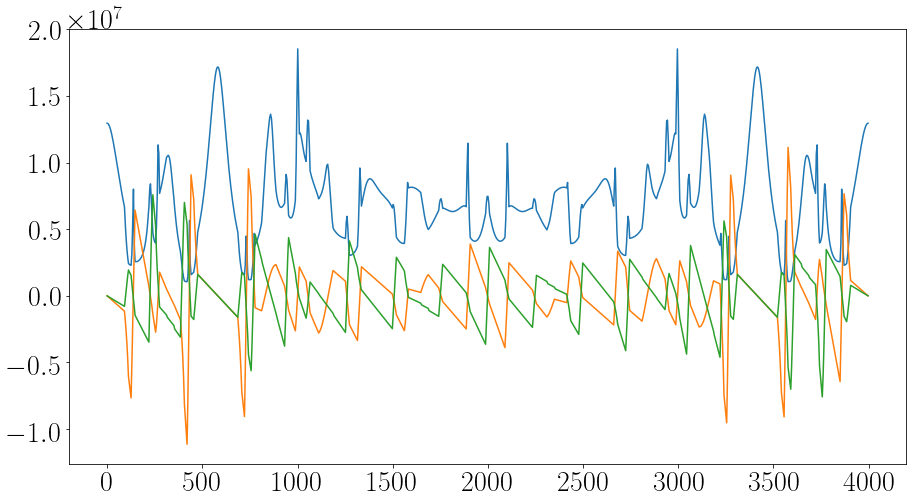

In [39]:
dN = 2*c/gamma**3*Ne**2/(64*np.pi**(3/2)*e1**2*e2**2*sz)\
    /(Apypy*Apxpx-1/4*Apxpy**2)\
    / np.sqrt(Fpx*Fpy-Fpxpy**2) * B
plt.plot(ldf['S_cm'], dN)
# plt.plot(ldf['S_cm'], 10000*ldf['Beta_cm_X'])
# plt.plot(ldf['S_cm'], 10000*ldf['Beta_cm_Y'])
plt.plot(ldf['S_cm'], 1000000*ldf['Alpha_X'])
plt.plot(ldf['S_cm'], 1000000*ldf['Alpha_Y'])

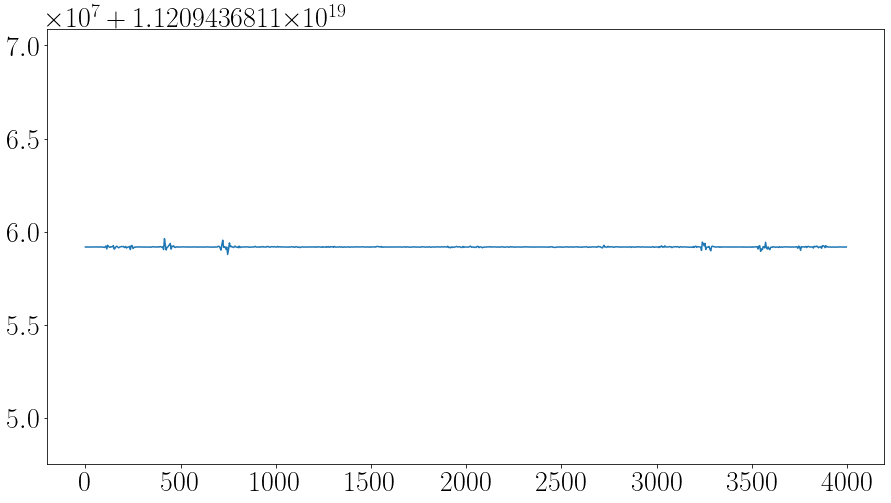

In [53]:
plt.plot(ldf['S_cm'], np.sqrt(Axx*Ayy)*np.sqrt(Fx*Fy)*np.sqrt(Apypy*Apxpx)*np.sqrt(Fpx*Fpy))

In [41]:
DN = (dN*ldf['dS']).sum()/ldf['dS'].sum()
tau = Ne/DN
tau

386.011567205603

In [42]:
from touschek.touschek import get_Touschek_Lifetime_Valishev

In [43]:
get_Touschek_Lifetime_Valishev(lattice_df, V0, sp, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor,
                         integration_upper_lim_rel=30)

386.011567205603

In [44]:
dict_Leb = {}
get_Touschek_Lifetime_Lebedev(lattice_df, V0, sp, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor,
                         test_dict=dict_Leb)

1128.4099005254252

In [45]:
dict_Val = {}
get_Touschek_Lifetime_Valishev(lattice_df, V0, sp, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor,
                         test_dict=dict_Val)

386.011567205603

# Cross check with Mathcad

In [46]:
ex = 5.82e-5*1e4
ey = 0.0037*ex
sz = 33.8
Ibeam = 3.185
V0 = 354
sp = 2.996e-4
get_Touschek_Lifetime_Lebedev(lattice_df, V0, sp, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511)

454.0330070927013

# Constant $\beta$ and zero $\alpha$ model

In [47]:
ldf = lattice_df

In [48]:
mldf = ldf.copy()
mldf['Beta_cm_X'] = 100
mldf['Beta_cm_Y'] = 100
mldf['Alpha_X'] = 0
mldf['Alpha_Y'] = 0
mldf['Dispersion_cm_X'] = 0
mldf['dDx'] = 0
mldf['dDx/dS'] = 0
mldf['Phi_X'] = 0
mldf['H'] = 0
mldf = mldf.drop(columns=['Sigma_um_X'])
dict_Leb = {}
leb = get_Touschek_Lifetime_Lebedev(mldf, V0, 1e-10, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511,
                         test_dict=dict_Leb)
dict_Val = {}
val = get_Touschek_Lifetime_Valishev(mldf, V0, 0, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511,
                         test_dict=dict_Val)

In [49]:
print("Lifetime (Leb) = ", leb)
print("Lifetime (Val) = ", val)
leb/val

Lifetime (Leb) =  332.57019786369415
Lifetime (Val) =  83.98032810205257


3.9600964342453646

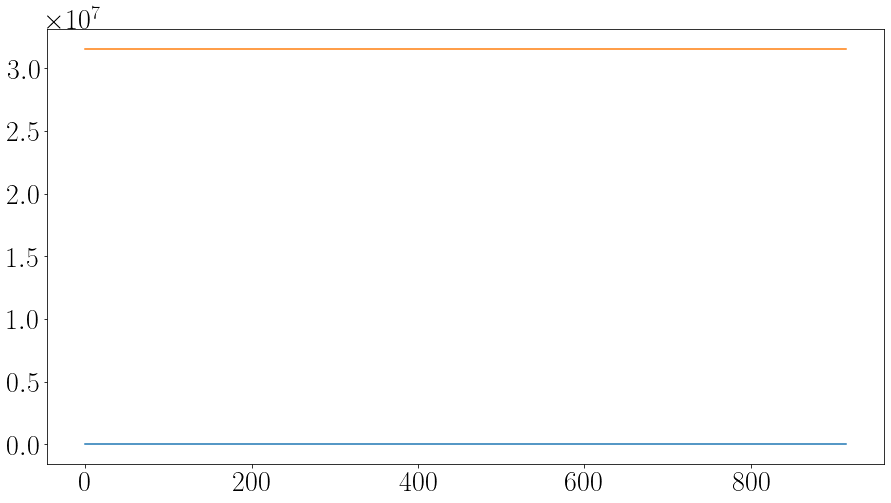

In [50]:
plt.plot(dict_Leb['Itski'])
plt.plot(dict_Val['dN'])